In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"
from tensorflow.keras import layers

if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. CNNs can be very slow without a GPU.")
    if IS_COLAB:
        print("Go to Runtime > Change runtime and select a GPU hardware accelerator.")
    if IS_KAGGLE:
        print("Go to Settings > Accelerator and select GPU.")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
tf.random.set_seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "cnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [ ]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F

# Load Data

In [ ]:
# mv /content/drive/MyDrive/kaggle.json ~/.kaggle/kaggle.json

In [ ]:
# import kaggle

In [ ]:
# !kaggle competitions download -c digit-recognizer

In [ ]:
# Upload data
# from zipfile import ZipFile

# file_name = "/content/digit-recognizer.zip"

#with ZipFile(file_name, 'r') as zip:
#  zip.extractall()
#  print('done')

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

In [ ]:
X_train_full.shape

(60000, 28, 28)

In [ ]:
y_train_full

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

In [ ]:
X_train_full = X_train_full / 255.
X_test = X_test / 255. 

X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [ ]:
X_submit = pd.read_csv("/content/drive/MyDrive/Projects/Digit Recognizer/Test Data/test.csv")
test = X_submit.to_numpy().reshape(28000,28,28)
test_image = X_submit.to_numpy().reshape(28000,28,28,1)
test_image = test_image.astype(float) / 255.0

num_classes = 10
input_shape = (28, 28, 1)

In [ ]:
test_image.shape

(28000, 28, 28, 1)

# Image Augmentation Layer

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomRotation(0.05),
  layers.experimental.preprocessing.RandomContrast(0.1),
  layers.experimental.preprocessing.RandomZoom(height_factor=(0.05,0.05))
])

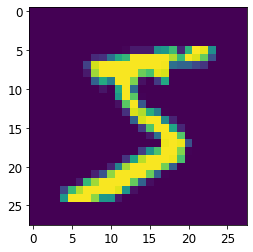

In [ ]:
image = next(iter(X_train_full))
_ = plt.imshow(image)

# **Modeling**

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.25),
        layers.Dense(128, activation="relu"),
        layers.Dense(64, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation="softmax"),
    ]
)

# Callbacks
checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=3, min_lr=0.0005)

es_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    min_delta=0.0001,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics = ["accuracy"])

history = model.fit(X_train, y_train, epochs=50, callbacks= [reduce_lr, model_checkpoint_callback, es_callback], validation_data=(X_valid, y_valid))
model.evaluate(X_test, y_test)

Epoch 1/50
1719/1719 [==============================] - 7s 4ms/step - loss: 0.2278 - accuracy: 0.9320 - val_loss: 0.0438 - val_accuracy: 0.9886
Epoch 2/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0831 - accuracy: 0.9778 - val_loss: 0.0415 - val_accuracy: 0.9882
Epoch 3/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0591 - accuracy: 0.9841 - val_loss: 0.0342 - val_accuracy: 0.9906
Epoch 4/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0493 - accuracy: 0.9867 - val_loss: 0.0397 - val_accuracy: 0.9904
Epoch 5/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0419 - accuracy: 0.9889 - val_loss: 0.0399 - val_accuracy: 0.9884
Epoch 6/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0366 - accuracy: 0.9900 - val_loss: 0.0457 - val_accuracy: 0.9898
Epoch 7/50
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0215 - accuracy: 0.9943 - val_loss: 0.0308 - val_accuracy:

[0.029974060133099556, 0.9939000010490417]

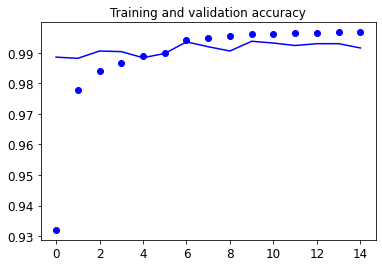

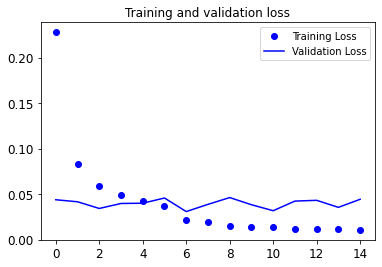

In [ ]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
y_pred = np.argmax(model.predict(test_image), axis=-1)

In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['Label']
print(y_pred.shape)
y_pred.head()

(28000, 1)


,Label
0,2
1,0
2,9
3,9
4,3


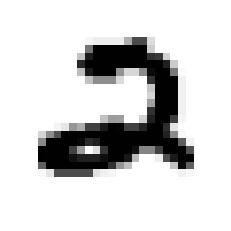

In [ ]:
plt.imshow(test[0], cmap="binary")
plt.axis("off")
plt.show()

In [ ]:
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['Label']
print(y_pred.shape)
y_pred.head()

(28000, 1)


,Label
0,2
1,0
2,9
3,9
4,3


In [ ]:
image_id = pd.DataFrame(y_pred.index + 1)
image_id.columns = ['ImageId']
image_id.head()

,ImageId
0,1
1,2
2,3
3,4
4,5


In [ ]:
submission = pd.concat([image_id, y_pred], axis=1)
submission.to_csv('submission.csv', index=False)